## Define soil parameters and layers

In [11]:
# Soil parameters
SMCMAX = 0.464  # m3/m3
SATPSI = 0.62   # m
DKSAT = 0.20E-5 # m/s
BEXP = 8.72     # -
DWSAT = BEXP * DKSAT * SATPSI / SMCMAX
SLOPE = 0.1     # -

# Time step
DT = 30.0 * 60.0    # s

def wdfcnd(smc):
    factr2 = min(1.0, max(0.0, smc / SMCMAX))
    expon = BEXP + 2.0
    wdf = DWSAT * (factr2 ** expon)     # Equation 3

    expon = 2.0 * BEXP + 3.0
    wcnd = DKSAT * (factr2 ** expon)    # Equation 2

    return wdf, wcnd

swc_initial = [0.3568, 0.3601, 0.3669, 0.3793]
nsoil = 4
zsoil = [-0.1, -0.4, -1.0, -2.0]
dsoil = [0.1, 0.3, 0.6, 1.0]

## Infiltration algorithm

In [12]:
import math

def capillary_drive(swc_b, swc):
    print(BEXP / (BEXP + 3) * SATPSI * (swc ** (BEXP + 3) - swc_b ** (BEXP + 3)))
    return BEXP / (BEXP + 3) * SATPSI * (swc ** (BEXP + 3) - swc_b ** (BEXP + 3))

def dry_depth (swc_b):
    tau = DT * DKSAT / (SMCMAX - swc_b)
    g = capillary_drive(swc_b, SMCMAX)

    return min(0.5 * (tau + math.sqrt(tau ** 2 + 4 * g * tau)), dsoil[0])

def wetting_front_layer(z):
    n = nsoil - 1
    for kz in range(nsoil):
        if z <= -zsoil[kz]:
            n = kz
            break

    ts = [0.0] * nsoil
    for kz in range(n + 1):
        ztop = 0.0 if kz == 0 else zsoil[kz - 1]
        ts[kz] = min(z + ztop, dsoil[kz])
        ts[kz] = max(ts[kz], 0.0)

    return n, ts


def swc_at_wetting_front(layer, tn, layer_depth, swc_b, swc):
    return min(max((swc * layer_depth - swc_b * (layer_depth - tn)) / tn, 0.02), SMCMAX)

def infiltration_capacity(z, swc_b):
    return DKSAT * capillary_drive(swc_b, SMCMAX) / z + DKSAT

def composite_conductivity(n, ts, swc_wfs):
    denominator = 0.0

    for kz in range(n + 1):
        _, wcnd = wdfcnd(swc_wfs[kz])
        denominator += ts[kz] / wcnd

    return z / denominator

def wetting_front_advance_rate(swc_wfs, swc_b, z, n, ts):
    return 1.0 / (swc_wfs[n] - swc_b) * (DKSAT * capillary_drive(swc_b, swc_wfs[n]) / z + composite_conductivity(n, ts, swc_wfs))

## Read precipitation, surface runoff, and evapotranspiration

In [13]:
import pandas as pd

noah_df = pd.read_csv('./HYDRO.TXT',
    sep='\s+',
)

prcp_array = (noah_df['PRCP']) / 1000.0 / DT   # from mm to m/s
pddum_array = (noah_df['PRCP'] - noah_df['RUNOFF11']) / 1000.0 / DT   # from mm to m/s
edir_array = noah_df['EDIR1S'] / 1000.0 / DT
et_array = noah_df['ETT1S'] / 1000.0 / DT

## Functions to solve Richards equations using Crank-Nicholson scheme

In [14]:
def srt(swc, pddum, edir, et):
    """Calculate the right hand side of the time tendency term of the soil water diffusion equation. Also compute
    (prepare) the matrix coefficients for the tri-diagonal matrix of the implicit time scheme.
        rhstt    - soil water time tendency
        runoff2  - sub surface runoff (baseflow)
        ai       - matrix coefficients
        bi       - matrix coefficients
        ci       - matrix coefficients
    """
    # Initialize the matrix coefficients and the right hand side of the soil water equation
    ai = [None] * nsoil
    bi = [None] * nsoil
    ci = [None] * nsoil
    rhstt = [None] * nsoil

    # Calculate the soil water diffusivity and hydraulic conductivity for the top layer
    wdf, wcnd = wdfcnd(swc[0])

    # Calculate the matrix coefficients ai, bi, and ci for the top layer
    ddz = 1.0 / (-0.5 * zsoil[1])
    ai[0] = 0.0
    bi[0] = wdf * ddz / (-zsoil[0])
    ci[0] = -bi[0]

    # Calculate rhstt for the top layer after calculating the vertical soil moisture gradient between the top and next
    # to top layers
    dsmdz = (swc[0] - swc[1]) / (-0.5 * zsoil[1])
    rhstt[0] = (wdf * dsmdz + wcnd - pddum + edir + et[0]) / zsoil[0]

    # Initialize ddz2
    ddz2 = 0.0

    # Loop through the remaining soil layers, repeating the above process
    for k in range(1, nsoil):
        denom2 = zsoil[k-1] - zsoil[k]

        # Slope of bottom layer is introduced
        slopx = SLOPE if k == nsoil - 1 else 1.0

        # retrieve the soil water diffusivity and hydraulic conductivity for this layer
        wdf2, wcnd2 = wdfcnd(swc[k])

        if k < nsoil - 1:
            # Calculate some partial products for later use in calculating rhstt
            denom = zsoil[k-1] - zsoil[k+1]
            dsmdz2 = (swc[k] - swc[k+1]) / (denom * 0.5)

            # Calculate the matrix coef, ci, after calculating its partial product
            ddz2 = 2.0 / denom
            ci[k] = -wdf2 * ddz2 / denom2
        else:   # k == nsoil - 1
            # Calculate a partial product for later use in calculating rhstt
            dsmdz2 = 0.0

            # Set matrix coef ci to zero
            ci[k] = 0.0

        # Calculate rhstt for this layer after calculating its numerator
        numer = wdf2 * dsmdz2 + slopx * wcnd2 - wdf * dsmdz - wcnd + et[k]
        rhstt[k] = numer / (-denom2)

        # Calculate matrix coefficients, ai, and bi for this layer
        ai[k] = -wdf * ddz / denom2
        bi[k] = -(ai[k] + ci[k])

        # Reset values of wdf, wcnd, dsmdz, and ddz for loop to next layer
        # runoff2:  sub-surface or baseflow runoff
        if k == nsoil - 1:
            runoff2 = slopx * wcnd2
        else:
            wdf = wdf2
            wcnd = wcnd2
            dsmdz = dsmdz2
            ddz = ddz2

    return ai, bi, ci, rhstt


def rosr12(a, b, d, c):
    """rosr12 inverts (solve) the tri-diagonal matrix problem shown below:
        ###                                            ### ###  ###   ###  ###
        #b(1), c(1),  0  ,  0  ,  0  ,   . . .  ,    0   # #      #   #      #
        #a(2), b(2), c(2),  0  ,  0  ,   . . .  ,    0   # #      #   #      #
        # 0  , a(3), b(3), c(3),  0  ,   . . .  ,    0   # #      #   # d(3) #
        # 0  ,  0  , a(4), b(4), c(4),   . . .  ,    0   # # p(4) #   # d(4) #
        # 0  ,  0  ,  0  , a(5), b(5),   . . .  ,    0   # # p(5) #   # d(5) #
        # .                                          .   # #  .   # = #   .  #
        # .                                          .   # #  .   #   #   .  #
        # .                                          .   # #  .   #   #   .  #
        # 0  , . . . , 0 , a(m-2), b(m-2), c(m-2),   0   # #p(m-2)#   #d(m-2)#
        # 0  , . . . , 0 ,   0   , a(m-1), b(m-1), c(m-1)# #p(m-1)#   #d(m-1)#
        # 0  , . . . , 0 ,   0   ,   0   ,  a(m) ,  b(m) # # p(m) #   # d(m) #
        ###                                            ### ###  ###   ###  ###
    """
    p = [None] * nsoil
    delta = [None] * nsoil


    # Initialize equation coefficient c for the lowest soil layer
    c[nsoil - 1] = 0.0

    # Solve the coefficients for the 1st soil layer
    p[0] = -c[0] / b[0]
    delta[0] = d[0] / b[0]

    # Solve the coefficients for soil layers 2 through nsoil
    for k in range(1, nsoil):
        p[k] = -c[k] * (1.0 / (b[k] + a[k] * p[k - 1]))
        delta[k] = (d[k] - a[k] * delta[k - 1]) * (1.0 / (b[k] + a[k] * p[k - 1]))

    # Set p to delta for lowest soil layer
    p[nsoil - 1] = delta[nsoil - 1]

    # Adjust p for soil layers 2 through nsoil
    for k in range(1, nsoil):
        kk = nsoil - 1 - k
        p[kk] = p[kk] * p[kk + 1] + delta[kk]

    return p


def sstep(swcin, ai, bi, ci, rhstt):
    """Create 'amount' values of variables to be input to the tri-diagonal matrix routine.
    """
    swcout = [None] * nsoil

    for k in range(nsoil):
        rhstt[k] *= DT
        ai[k] *= DT
        bi[k] = 1. + bi[k] * DT
        ci[k] *= DT

    # Copy values for input variables before call to rosr12
    rhsttin = rhstt.copy()
    ciin = ci.copy()

    # Call rosr12 to solve the tri-diagonal matrix
    ci = rosr12(ai, bi, rhsttin, ciin)

    # Sum the previous smc value and the matrix solution to get a new value. min allowable value of smc will be 0.02.
    #      runoff3: runoff within soil layers
    wplus   = 0.0
    runoff3 = 0.0
    ddz = -zsoil[0]

    for k in range(nsoil):
        if k != 0: ddz = zsoil[k - 1] - zsoil[k]

        swcout[k] = swcin[k] + ci[k] + wplus / ddz

        stot = swcout[k]
        if stot > SMCMAX:
            if k == 0:
                ddz = -zsoil[0]
            else:
                kk11 = k - 1
                ddz = -zsoil[k] + zsoil[kk11]
            wplus = (stot - SMCMAX) * ddz
        else:
            wplus = 0.0

        swcout[k] = max(swcout[k], 0.02)

    runoff3 = wplus

    return swcout

## Loop through time steps to solve for soil water content

In [15]:
# Initialize wetting front depth
z = 0.0
surface_water = 0.0
swc_bs = swc_initial.copy()
swc_wfs = [0.0] * nsoil
swc = [swc_initial]
swc_ga = [swc_initial]
infiltrations = []

for k in range(len(pddum_array)):
    prcp = prcp_array[k]
    pddum = pddum_array[k]
    edir = edir_array[k]
    et = [et_array[k] * dsoil[kz] / sum(dsoil) for kz in range(len(dsoil))]

    # Calculate infiltration rate
    if prcp + surface_water / DT == 0.0:
        infiltration = 0.0
        z = 0.0
        swc_bs = swc_ga[-1].copy()
        swc_wfs = [0.0] * nsoil
    else:
        if z == 0.0:    # Initial wetting front depth
            z = dry_depth(swc_ga[-1][0])

        # Find location of wetting front
        n, ts = wetting_front_layer(z)

        # Calculate infiltration capacity
        infil_pot = infiltration_capacity(z, swc_bs[n])

        if prcp + surface_water / DT > infil_pot:
            infiltration = infil_pot
            surface_water += (prcp - infil_pot) * DT
        else:
            infiltration = prcp + surface_water / DT
            surface_water = 0.0

    surface_water = 0

    ai, bi, ci, rhstt = srt(swc[-1], pddum, edir, et)
    swc.append(sstep(swc[-1], ai, bi, ci, rhstt))

    infiltrations.append(infiltration)
    ai, bi, ci, rhstt = srt(swc_ga[-1], infiltration, edir, et)
    swc_ga.append(sstep(swc_ga[-1], ai, bi, ci, rhstt))


    if z > 0.0:
        # Calculate wetting front depth
        for kz in range(n + 1):
            if kz < n:
                swc_wfs[kz] = swc_ga[-1][kz]
                swc_bs[kz] = 0.0
            elif kz == n:
                swc_wfs[kz] = swc_at_wetting_front(kz, ts[kz], dsoil[kz], swc_bs[kz], swc_ga[-1][kz])
            else:
                swc_wfs[kz] = 0.0
                swc_bs[kz] = swc_ga[-1][kz]

        z += wetting_front_advance_rate(swc_wfs, swc_bs[n], z, n, ts) * DT


5.5247158768838125e-05
5.524792012679976e-05
1.204309183818296e-06
5.524792012679976e-05
2.779642198574585e-06
5.468317279445252e-05
5.4623364263639944e-05
5.519509145870816e-06
5.4623364263639944e-05
4.620019916890645e-06
5.483542908900426e-05
5.483184506878199e-05
5.622354792708245e-07
5.483184506878199e-05
1.1098316506810268e-06
5.483184506878199e-05
1.6263278385596973e-06
5.483184506878199e-05
2.9534487422891478e-06
5.483184506878199e-05
3.2101041266196663e-06
5.407388668541499e-05
5.397915082403369e-05
1.376399890365142e-07
5.402668619923006e-05
5.393218678722402e-05
9.526476286708215e-06
5.393218678722402e-05
2.594853948478222e-05
5.085328729662563e-05
4.902695453172672e-05
-7.017429478763023e-07
4.902695453172672e-05
1.7930252310548474e-05
4.902695453172672e-05
-1.061490198483383e-06
4.902695453172672e-05
-5.038974280002518e-06
5.1438664000217736e-05
5.095461862174873e-05
-1.0481100281122847e-06
5.398004531843075e-05
5.3977576161131414e-05
1.3981068460478555e-05
5.42754782346966

## Plot results and compare with Noah

[-0.1, -0.4, -1.0, -2.0]


/var/folders/vl/cg0s8ltd5h724vq3k_66g91m0000gn/T/ipykernel_27919/2855075547.py:30: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  fig.tight_layout()


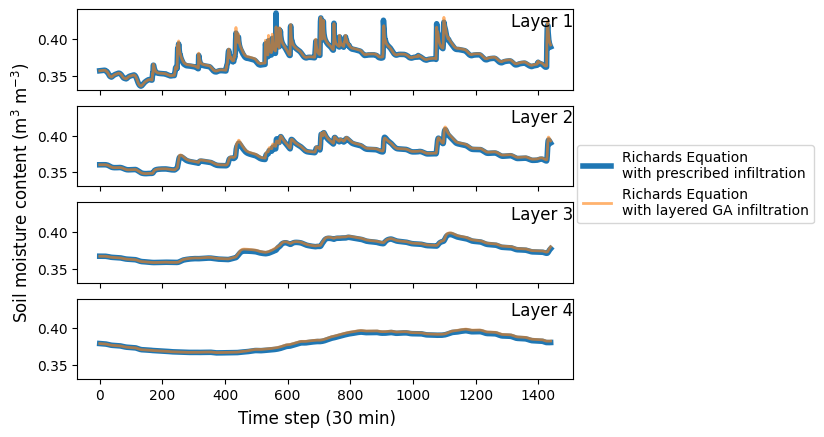

In [16]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(
    4, 1,
    sharex=True,
    sharey=True,
)
print(zsoil)
for k in range(len(zsoil)):
    axs[k].plot(
        np.array(swc)[:, k],
        lw=4,
        label=f'Richards Equation\nwith prescribed infiltration'
    )
    axs[k].plot(
        np.array(swc_ga)[:, k],
        lw=2,
        alpha=0.6,
        label=f'Richards Equation\nwith layered GA infiltration',
    )
    axs[k].set_title(
        f'Layer {k+1}',
        loc='right',
        y=1.0, pad=-12
    )
plt.legend(bbox_to_anchor=(1.5, 3))
fig.supxlabel('Time step (30 min)')
fig.supylabel('Soil moisture content (m$^3$ m$^{-3}$)')
fig.tight_layout()

/var/folders/vl/cg0s8ltd5h724vq3k_66g91m0000gn/T/ipykernel_27919/2251471525.py:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  ax.plot(lims, lims, 'k--', color=[0.5, 0.5, 0.5])


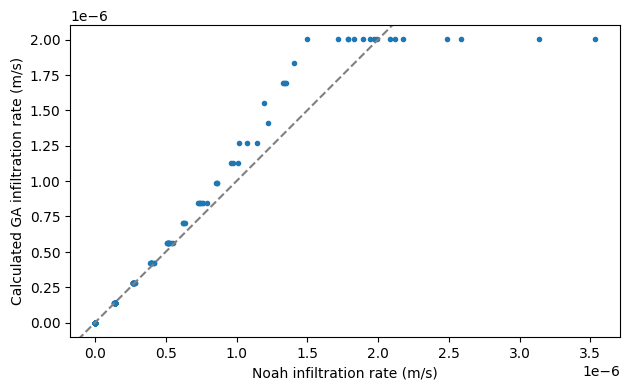

In [25]:
fig, ax = plt.subplots()
ax.plot(pddum_array, infiltrations, '.')
ax.set_xlabel('Noah infiltration rate (m/s)')
ax.set_ylabel('Calculated GA infiltration rate (m/s)')
ax.set_aspect('equal')
x_range = ax.get_xlim()
y_range = ax.get_ylim()
lims = [
    min(x_range[0], y_range[0]),
    max(x_range[1], y_range[1]),
]
ax.plot(lims, lims, 'k--', color=[0.5, 0.5, 0.5])
ax.set_xlim(x_range)
ax.set_ylim(y_range)
fig.tight_layout()